# ESP polar scan 

The purpose of this jupyter notebook is to visualize the pickle files generated from the chl_analyzer.py script. 

Just as reminder, these are the ring substituent in known chlorophyll types:

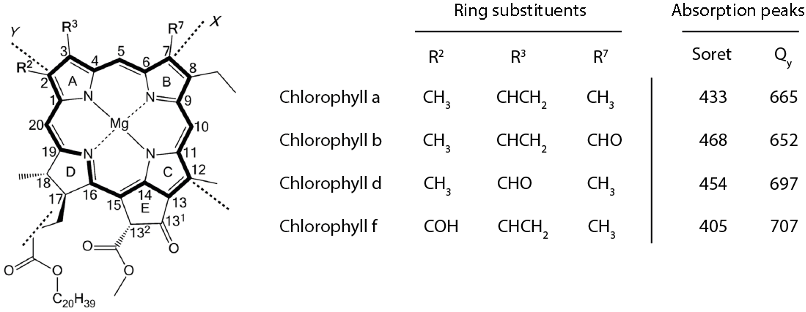

After importing the packages and the .pickle generated from the script you'll be able to take a look at specific "cones" as well as to analyze the performance on a given Map/Model combination. The results obtained have to be interpreted together with structural analysis and are supposed to be just an extra aid to other lines of evidence. 

If anything is not clear, you have any questions or suggestions get in touch with me at gconsoli@ic.ac.uk 

In [ ]:
pip install matplotlib numpy pandas scipy seaborn

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from scipy.stats import skew, kurtosis

# Set seaborn styling
sns.set_theme()
sns.set_context("talk")
sns.set_style("ticks")

In [12]:
def print_extreme_values(df, row, column):
    """
    Print the highest and lowest values for a given Chl substituent.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    row (str): The index label of the row.
    column (str): The column label.
    """
    # Retrieve the array from the specified cell
    array = df.at[row, column]

    # Compute the highest and lowest values
    highest_number = np.max(array)
    lowest_number = np.min(array)

    # Print the results
    print(f"Highest Z-score value: {highest_number}")
    print(f"Lowest Z-score value: {lowest_number}")


# Example usage
# Assuming Z_scores_df is your DataFrame and you want to analyze the cell at row "A1012" and column "C2"
# print_extreme_values(Z_scores_df, "A1012", "C2")


def count_outliers(df, cutoff):
    """
    Counts the number of cells with outliers in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    cutoff (float): The threshold to consider a value as an outlier.

    Returns:
    pd.Series: Count of outliers for each column.
    """

    def has_outliers(arr, cutoff):
        return np.any((arr > cutoff) | (arr < -cutoff))

    return df.map(lambda x: has_outliers(x, cutoff)).sum()


def polar_plot_df(df, cmap="RdBu_r"):
    """
    Generate polar plots for each row and column in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data to plot.
    cmap (str): The color map to use for the plots.
    """
    num_columns = df.shape[1]
    figure_width = 6 * num_columns
    theta = np.linspace(0, 2 * np.pi, 72)
    r = np.round(np.linspace(0, 2.5, 26), decimals=1)
    theta_grid = np.linspace(0, 2 * np.pi, len(theta), endpoint=False) - np.pi / 2
    theta_grid, r_grid = np.meshgrid(theta, r)
    theta_grid = np.linspace(0, 2 * np.pi, len(theta), endpoint=False) - np.pi / 2

    # Iterate over the rows and columns
    for row_idx, row_label in enumerate(df.index):
        # Create plots for each column
        fig, axes = plt.subplots(
            1,
            num_columns,
            figsize=(figure_width, 5),
            subplot_kw={"projection": "polar"},
        )
        axes = axes.flatten()

        # Initialize max and min values
        all_values = []

        # Validate and collect all values for scaling
        for column in df.columns:
            data = df.at[row_label, column]
            if isinstance(data, np.ndarray) and data.ndim == 2:
                all_values.append(data.flatten())
            else:
                # Hide subplot and notify if the data is invalid
                axes[df.columns.get_loc(column)].set_visible(False)

        if all_values:
            all_values = np.concatenate(all_values)
            max_value = np.max(np.abs(all_values))
            vmin = -max_value
            vmax = max_value

            # Plot each heatmap
            for i, column in enumerate(df.columns):
                data = df.at[row_label, column]
                if isinstance(data, np.ndarray) and data.ndim == 2:
                    cax = axes[i].pcolormesh(
                        theta_grid,
                        r_grid,
                        data,
                        cmap=cmap,
                        vmin=vmin,
                        vmax=vmax,
                        shading="auto",
                    )
                    fig.colorbar(cax, ax=axes[i], pad=0.15)
                    axes[i].set_title(f"{row_label} - {column}")
                else:
                    # Set title for invalid data
                    axes[i].set_title(f"{row_label} - {column} (Invalid Data)")

        else:
            print(f"Skipping row {row_label} as all data is invalid.")

        # Display the plots
        fig.tight_layout()
        plt.show()


def find_outlier_chlorophylls(df, column, cutoff=3):
    """
    Identify chlorophyll numbers where any value in the specified column exceeds the cutoff.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    column (str): The column to check for outliers.
    cutoff (float): The cutoff value to detect significant deviations.

    Returns:
    list of str: Chlorophyll numbers with values exceeding the cutoff.
    """
    outlier_chlorophylls = []
    for chlorophyll in df.index:
        data = df.at[chlorophyll, column]
        if np.any((data > cutoff) | (data < -cutoff)):
            outlier_chlorophylls.append(chlorophyll)
    return outlier_chlorophylls


def polar_plot_substituent(df1, df2, chlorophyll_numbers, substituent):
    """
    Plot polar plots for specific cells in two DataFrames for rows with outliers.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame containing ESP data.
    df2 (pd.DataFrame): The second DataFrame containing Z-score data.
    chlorophyll_numbers (list of str): List of row labels in the DataFrames with outliers.
    substituent (str): The column label in the DataFrames.
    """
    # Default parameters
    figure_width = 15
    vmin2, vmax2 = -5, 5
    theta = np.linspace(0, 2 * np.pi, 72)
    r = np.round(np.linspace(0, 2.5, 26), decimals=1)
    theta_grid = np.linspace(0, 2 * np.pi, len(theta), endpoint=False) - np.pi / 2
    r_grid = np.round(np.linspace(0, 2.5, 26), decimals=1)
    theta_grid, r_grid = np.meshgrid(theta, r)
    theta_grid = np.linspace(0, 2 * np.pi, len(theta), endpoint=False) - np.pi / 2

    # Iterate over the list of chlorophyll numbers
    for chlorophyll_number in chlorophyll_numbers:
        # Retrieve the data
        data_test = df1.at[chlorophyll_number, substituent]
        data_zscore = df2.at[chlorophyll_number, substituent]

        # Create the plot if the condition is met
        fig, axs = plt.subplots(
            1, 2, figsize=(figure_width, 5), subplot_kw={"projection": "polar"}
        )

        # Plot for df1 (ESP data)
        max_abs_test = np.max(np.abs(data_test))
        vmin1 = -max_abs_test
        vmax1 = max_abs_test

        cax_test = axs[0].pcolormesh(
            theta_grid,
            r_grid,
            data_test,
            cmap="RdBu_r",
            vmin=vmin1,
            vmax=vmax1,
            shading="auto",
        )
        cb_test = fig.colorbar(cax_test, ax=axs[0], pad=0.15)
        cb_test.set_label("ESP (A.U.)")
        axs[0].set_title(f"{chlorophyll_number} - {substituent} - map ESP", y=1.1)
        axs[0].set_yticklabels([])

        # Plot for df2 (Z-score data)
        cax_zscore = axs[1].pcolormesh(
            theta_grid,
            r_grid,
            data_zscore,
            cmap="Spectral_r",
            vmin=vmin2,
            vmax=vmax2,
            shading="auto",
        )
        cb_zscore = fig.colorbar(cax_zscore, ax=axs[1], pad=0.15)
        cb_zscore.set_label("Z-score")
        axs[1].set_title(f"{chlorophyll_number} - {substituent} - Z score", y=1.1)
        axs[1].set_yticklabels([])

        # Add gridlines manually
        for radius in np.linspace(0, 1, 5):
            for ax in axs:
                ax.plot(
                    theta, [radius] * len(theta), color="grey", alpha=0.2, linewidth=0.5
                )

        plt.subplots_adjust(top=1.2)
        fig.tight_layout()
        plt.show()


def plot_metrics_over_cutoffs(df, start_cutoff=1, end_cutoff=5, step=0.1):
    """
    Plot precision, recall, and accuracy over a range of cutoff values.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    start_cutoff (float): The starting cutoff value.
    end_cutoff (float): The ending cutoff value.
    step (float): The interval between cutoff values.

    Returns:
    None: Displays the plot of metrics over cutoffs.
    """
    cutoffs = np.arange(start_cutoff, end_cutoff + step, step)
    precisions, recalls, accuracies = [], [], []

    for cutoff in cutoffs:
        results = count_outliers(df, cutoff)
        chlorophylls = len(df)

        true_positives_C3_C8 = results["C3"] + results["C8"]
        false_negatives_C3_C8 = chlorophylls * 2 - true_positives_C3_C8
        false_positives_C7_C12 = results["C7"] + results["C12"]
        true_negatives_C7_C12 = chlorophylls * 2 - false_positives_C7_C12

        precision = (
            true_positives_C3_C8 / (true_positives_C3_C8 + false_positives_C7_C12)
        ) * 100
        recall = (
            true_negatives_C7_C12 / (true_negatives_C7_C12 + false_negatives_C3_C8)
        ) * 100
        accuracy = (
            (true_positives_C3_C8 + true_negatives_C7_C12) / (chlorophylls * 4)
        ) * 100

        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)

    plt.figure(figsize=(12, 6))
    plt.plot(cutoffs, precisions, label="Precision")
    plt.plot(cutoffs, recalls, label="Recall")
    plt.plot(cutoffs, accuracies, label="Accuracy")

    plt.xlabel("Cutoff Z-score")
    plt.ylabel("Percentage (%)")
    plt.title("Performance Metrics over Cutoff Values")
    plt.legend()
    plt.grid(True)
    plt.show()

def find_outlier_chlorophylls_by_distance(df, column, cutoff=3, distance=2.5):
    """
    Identify chlorophyll numbers where values in a specified portion of the array exceed the cutoff.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    column (str): The column to check for outliers.
    cutoff (float): The cutoff value to detect significant deviations.
    distance (float): The maximum distance (0 to 2.5) for selecting rows in the 26-dimension axis.

    Returns:
    list of str: Chlorophyll numbers with values exceeding the cutoff in the selected portion.
    """
    # Calculate the number of rows to include based on the distance
    max_row = int((distance / 2.5) * 26)
    
    outlier_chlorophylls = []
    for chlorophyll in df.index:
        data = df.at[chlorophyll, column]
        # Slice the array to only include rows up to max_row
        data_subset = data[:max_row, :]
        if np.any((data_subset > cutoff) | (data_subset < -cutoff)):
            outlier_chlorophylls.append(chlorophyll)
    return outlier_chlorophylls
def get_statistics_df(df: pd.DataFrame, selected_data: list) -> pd.DataFrame:
    """
    Calculate the mean and standard deviation for columns in a DataFrame where each cell is a 26x72 array.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 26x72 arrays in each cell.
    selected_data (list): List of column names to analyze.

    Returns:
    pd.DataFrame: A DataFrame with two rows ('Average' and 'Standard Deviation') and the same columns.
    """
    # Initialize the stats DataFrame
    stats_df = pd.DataFrame(index=["Average", "Standard Deviation"])

    for column in selected_data:
        # Get the number of rows (number of 26x72 arrays)
        num_chl = len(df[column])

        # Calculate the average array for this column
        avg = np.mean(np.stack(df[column].values), axis=0)
        
        # Calculate the standard deviation array for this column
        std_dev = np.sqrt(
            np.sum([(chl - avg) ** 2 for chl in df[column]], axis=0) / num_chl
        )

        # Add results to the stats DataFrame
        stats_df[column] = [avg, std_dev]

    return stats_df

def count_outliers(df, cutoff, distance=2.5):
    """
    Counts the number of cells with outliers in the DataFrame, considering only rows up to a specified distance.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    cutoff (float): The threshold to consider a value as an outlier.
    distance (float): The maximum distance (0 to 2.5) for selecting rows in the 26-dimension axis.

    Returns:
    pd.Series: Count of outliers for each column.
    """
    # Determine the number of rows to include based on distance
    max_row = int((distance / 2.5) * 26)

    def has_outliers(arr, cutoff):
        # Slice the array to include only rows up to max_row
        sliced_arr = arr[:max_row, :]
        return np.any((sliced_arr > cutoff) | (sliced_arr < -cutoff))

    # Apply the has_outliers function to each cell
    return df.map(lambda x: has_outliers(x, cutoff)).sum()

def plot_metrics_over_cutoffs(df, start_cutoff=1, end_cutoff=5, step=0.1, distance=2.5):
    """
    Plot precision, recall, accuracy, and F1 score over a range of cutoff values 
    with an optional maximum distance for analysis.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    start_cutoff (float): The starting cutoff value.
    end_cutoff (float): The ending cutoff value.
    step (float): The interval between cutoff values.
    distance (float): The maximum distance (0 to 2.5) for selecting rows in the 26-dimension axis.
    save_to_csv (str): The file path to save the results as a CSV. If None, no file will be saved.

    Returns:
    pd.DataFrame: DataFrame containing metrics for each cutoff.
    """
    cutoffs = np.arange(start_cutoff, end_cutoff + step, step)
    results_df = pd.DataFrame(columns=['Cutoff', 'Precision', 'Recall', 'Accuracy', 'F1'])

    precisions, recalls, accuracies, f1_scores = [], [], [], []

    for cutoff in cutoffs:
        results = count_outliers(df, cutoff, distance=distance)
        chlorophylls = len(df)

        true_positives_C3_C8 = results["C3"] + results["C8"]
        false_negatives_C3_C8 = chlorophylls * 2 - true_positives_C3_C8
        false_positives_C7_C12 = results["C7"] + results["C12"]
        true_negatives_C7_C12 = chlorophylls * 2 - false_positives_C7_C12

        precision = (
            true_positives_C3_C8 / (true_positives_C3_C8 + false_positives_C7_C12)
        ) * 100
        recall = (
            true_negatives_C7_C12 / (true_negatives_C7_C12 + false_negatives_C3_C8)
        ) * 100
        accuracy = (
            (true_positives_C3_C8 + true_negatives_C7_C12) / (chlorophylls * 4)
        ) * 100

        # Calculate F1 score
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0  # Avoid division by zero if both precision and recall are zero

        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1_scores.append(f1)

        # Append metrics to results DataFrame
        results_df = pd.concat(
            [results_df, pd.DataFrame({'Cutoff': [cutoff], 'Precision': [precision],
                                       'Recall': [recall], 'Accuracy': [accuracy],
                                       'F1': [f1]})],
            ignore_index=True
        )

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(cutoffs, precisions, label="Precision")
    plt.plot(cutoffs, recalls, label="Recall")
    plt.plot(cutoffs, accuracies, label="Accuracy")
    plt.plot(cutoffs, f1_scores, label="F1 Score")

    plt.xlabel("Cutoff Z-score")
    plt.ylabel("Percentage (%)")
    plt.title("Performance Metrics over Cutoff Values")
    plt.legend()
    plt.grid(True)
    plt.show()

def get_filtered_statistics_df(
    df: pd.DataFrame, selected_data: list, lower_bound: float, upper_bound: float
) -> pd.DataFrame:
    """
    Calculate the mean and standard deviation for columns in a DataFrame where each cell is a 26x72 array,
    but only for rows where the 'loc_res_Mg' column value is within specified boundaries.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 26x72 arrays in specified columns and a filtering column 'loc_res_Mg'.
    selected_data (list): List of column names to analyze.
    lower_bound (float): Lower boundary for filtering rows based on 'loc_res_Mg'.
    upper_bound (float): Upper boundary for filtering rows based on 'loc_res_Mg'.

    Returns:
    pd.DataFrame: A DataFrame with two rows ('Average' and 'Standard Deviation') and the same columns.
    """
    # Filter rows based on 'loc_res_Mg' boundaries
    filtered_df = df[(df["loc_res_Mg"] >= lower_bound) & (df["loc_res_Mg"] <= upper_bound)]

    # Initialize the stats DataFrame
    stats_df = pd.DataFrame(index=["Average", "Standard Deviation"])

    for column in selected_data:
        # Get the number of rows (number of 26x72 arrays) after filtering
        num_chl = len(filtered_df[column])

        # Check if there are enough rows for calculations
        if num_chl == 0:
            raise ValueError("No rows match the filtering criteria. Adjust the boundaries.")

        # Calculate the average array for this column
        avg = np.mean(np.stack(filtered_df[column].values), axis=0)
        
        # Calculate the standard deviation array for this column
        std_dev = np.sqrt(
            np.sum([(chl - avg) ** 2 for chl in filtered_df[column]], axis=0) / num_chl
        )

        # Add results to the stats DataFrame
        stats_df[column] = [avg, std_dev]

    return stats_df

def get_zscores_df(
    df: pd.DataFrame, df_stats_filtered: pd.DataFrame, ref_substituent: str
) -> pd.DataFrame:
    zscores_df = pd.DataFrame(index=df.index, columns=["C2", "C3", "C7", "C8", "C12"])

    # Loop over the rows in the original dataframe
    for row_idx, row in df.iterrows():
        for substituent in ["C2", "C3", "C7", "C8", "C12"]:
            # Get the corresponding mean and standard deviation from df_stats_filtered for the ref_substituent (e.g., "C7")
            mean_value = df_stats_filtered.at["Average", ref_substituent]
            std_value = df_stats_filtered.at["Standard Deviation", ref_substituent]
            
            # Calculate the z-score using the provided ref_substituent statistics (C7)
            z = (row[substituent] - mean_value) / std_value
            zscores_df.loc[row_idx, substituent] = z

    return zscores_df

def plot_loc_res_mg_with_outliers(df: pd.DataFrame, outliers: list, figsize=(20, 8)):
    """
    Plot the values of 'loc_res_Mg' for each row in the DataFrame and color outlier rows differently.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the 'loc_res_Mg' column.
        outliers (list): A list of indices (row labels) flagged as outliers.
        figsize (tuple): The size of the plot.

    Returns:
        None
    """
    # Ensure that loc_res_Mg exists in the DataFrame
    if "loc_res_Mg" not in df.columns:
        raise ValueError("Column 'loc_res_Mg' is not in the DataFrame.")

    # Sort the DataFrame by loc_res_Mg values for visualization purposes
    sorted_df = df.sort_values(by="loc_res_Mg").copy()

    # Create a color list for each row in the sorted DataFrame
    colors = ["orange" if idx in outliers else "blue" for idx in sorted_df.index]

    # Set the figure size
    plt.figure(figsize=figsize)

    # Create the scatter plot
    sns.scatterplot(
        x=sorted_df.index,  # Plot using the sorted indices
        y=sorted_df["loc_res_Mg"],  # Plot sorted loc_res_Mg values
        s=100,
        palette=None,
        color=colors,  # Use the dynamic color list
        edgecolor="black",
    )

    # Customize the plot
    plt.title("Values of loc_res_Mg for Each Row (Outliers Highlighted)", fontsize=16)
    plt.xlabel("Row Labels (Sorted by loc_res_Mg)", fontsize=14)
    plt.ylabel("loc_res_Mg", fontsize=14)
    plt.xticks(rotation=45, fontsize=12, ha="right")
    plt.yticks(fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()
    
def plot_loc_res_mg_distribution(df: pd.DataFrame, bins=20, kde=True, figsize=(10, 6)):
    """
    Plot the distribution of 'loc_res_Mg' values in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the 'loc_res_Mg' column.
        bins (int): Number of bins for the histogram (default is 20).
        kde (bool): Whether to include a kernel density estimate (default is True).
        figsize (tuple): The size of the plot.

    Returns:
        None
    """
    # Ensure that loc_res_Mg exists in the DataFrame
    if "loc_res_Mg" not in df.columns:
        raise ValueError("Column 'loc_res_Mg' is not in the DataFrame.")

    # Set up the figure
    plt.figure(figsize=figsize)

    # Plot the distribution
    sns.histplot(
        df["loc_res_Mg"],
        bins=bins,
        kde=kde,  # Add a KDE curve if desired
        color="green",
        edgecolor="black",
    )

    # Customize the plot
    plt.title("Distribution of loc_res_Mg Values", fontsize=16)
    plt.xlabel("loc_res_Mg", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0,60)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def analyze_min_max_distributions(df, column_name, row_range=(0, 26)):
    """
    Analyzes the min and max distributions of (26,72) arrays within a DataFrame column, 
    allowing control over how many rows are included in the analysis.

    Parameters:
        df (pd.DataFrame): DataFrame containing (26,72) arrays as cells.
        column_name (str): Column to analyze.
        row_range (tuple): (start, end) row indices to include (default: all 26 rows).

    Returns:
        pd.DataFrame: Extracted max and min values.
    """
    max_values = []
    min_values = []

    start, end = row_range  # Unpack the row range

    for array in df[column_name]:
        if isinstance(array, np.ndarray) and array.shape == (26, 72):
            selected_region = array[start:end, :]  # Select the specified rows
            max_values.append(selected_region.max())  
            min_values.append(selected_region.min())  
        else:
            raise ValueError(f"Unexpected data format in column {column_name}: Expected (26,72) arrays.")

    # Convert to DataFrame
    extracted_df = pd.DataFrame({"Max Values": max_values, "Min Values": min_values})

    # Compute skewness
    max_skew = skew(extracted_df["Max Values"])
    min_skew = skew(extracted_df["Min Values"])

    # Compute mean & median
    max_mean, max_median = extracted_df["Max Values"].mean(), extracted_df["Max Values"].median()
    min_mean, min_median = extracted_df["Min Values"].mean(), extracted_df["Min Values"].median()

    print(f"Max Values - Skewness: {max_skew:.3f}, Mean: {max_mean:.3f}, Median: {max_median:.3f}")
    print(f"Min Values - Skewness: {min_skew:.3f}, Mean: {min_mean:.3f}, Median: {min_median:.3f}")

    # Plot histograms with KDE
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(extracted_df["Min Values"], kde=True, bins=30, ax=axes[0], color="#17BEBB")
    axes[0].set_title(f"Distribution of Min Values (Rows {start}-{end-1})")

    sns.histplot(extracted_df["Max Values"], kde=True, bins=30, ax=axes[1], color="#EF3E36")
    axes[1].set_title(f"Distribution of Max Values (Rows {start}-{end-1})")

    plt.tight_layout()
    plt.show()

In [13]:
# Import your pickle files here:
structure = "9EYS"
base_name = f"data/{structure}/{structure}"

structure_dict = {
    "PSII_esp": f"{base_name}_conedata.pickle",
    "PSII_zscores": f"{base_name}_zscores.pickle",
    "PSII_stats": f"{base_name}_stats.pickle",
}
structure_list = list(structure_dict.keys())


for key, value in structure_dict.items():
    # Open the file with the name stored in the value
    with open(value, "rb") as handle:
        # Read the contents of the file
        data = pickle.load(handle)
        globals()[key] = pd.DataFrame.from_dict(data)
PSII_esp

,loc_res_Mg,C2,C3,C7,C8,C12
A1011,2.063040,"[[0.18885875881948114, 0.18885875881948114, 0....","[[0.2170044728072491, 0.2170044728072491, 0.21...","[[0.19199072057458, 0.19199072057458, 0.191990...","[[0.2400915009642374, 0.2400915009642374, 0.24...","[[0.1914613118843722, 0.1914613118843722, 0.19..."
A1012,2.063040,"[[0.22586994003191996, 0.22586994003191996, 0....","[[0.23489989557081928, 0.23489989557081928, 0....","[[0.22508099609023605, 0.22508099609023605, 0....","[[0.22861574032150805, 0.22861574032150805, 0....","[[0.21928402940713038, 0.21928402940713038, 0...."
A1013,2.063040,"[[0.18936714958526885, 0.18936714958526885, 0....","[[0.1975057275944331, 0.1975057275944331, 0.19...","[[0.21001866564341967, 0.21001866564341967, 0....","[[0.22396173424658, 0.22396173424658, 0.223961...","[[0.1861531127408069, 0.1861531127408069, 0.18..."
A1101,2.163435,"[[0.08613864739908027, 0.08613864739908027, 0....","[[0.12302138628074555, 0.12302138628074555, 0....","[[0.11510311245641965, 0.11510311245641965, 0....","[[0.15590163435853835, 0.15590163435853835, 0....","[[0.13688875003084902, 0.13688875003084902, 0...."
A1102,2.073102,"[[0.13142010052140082, 0.13142010052140082, 0....","[[0.15594159020219442, 0.15594159020219442, 0....","[[0.11641725652408189, 0.11641725652408189, 0....","[[0.16275511481097354, 0.16275511481097354, 0....","[[0.14909102023273585, 0.14909102023273585, 0...."
...,...,...,...,...,...,...
K6004,2.481906,"[[0.04665810128185789, 0.04665810128185789, 0....","[[0.0670823991648138, 0.0670823991648138, 0.06...","[[0.056838596630326754, 0.056838596630326754, ...","[[0.07266061822641354, 0.07266061822641354, 0....","[[0.06019452561630988, 0.06019452561630988, 0...."
L1501,2.063040,"[[0.17398237924738774, 0.17398237924738774, 0....","[[0.20394791586475883, 0.20394791586475883, 0....","[[0.1820326698237639, 0.1820326698237639, 0.18...","[[0.1969232456809203, 0.1969232456809203, 0.19...","[[0.17806160514704555, 0.17806160514704555, 0...."
L1502,2.063040,"[[0.181969507640896, 0.181969507640896, 0.1819...","[[0.1794198012768922, 0.1794198012768922, 0.17...","[[0.18736088908472123, 0.18736088908472123, 0....","[[0.21167901817306772, 0.21167901817306772, 0....","[[0.2015754872382458, 0.2015754872382458, 0.20..."
L1503,2.063036,"[[0.2359522858870755, 0.2359522858870755, 0.23...","[[0.16602602936894983, 0.16602602936894983, 0....","[[0.15139350219031797, 0.15139350219031797, 0....","[[0.19574613903857227, 0.19574613903857227, 0....","[[0.15225245643609708, 0.15225245643609708, 0...."


# Calculating the average and standard deviation of each substituent

this box recalculates the average and standard deviation of all the Chl substituents, then calculates a dataframe containing the Z-scores for each of the pigments based the Ave and Std of a substituent of choice. 

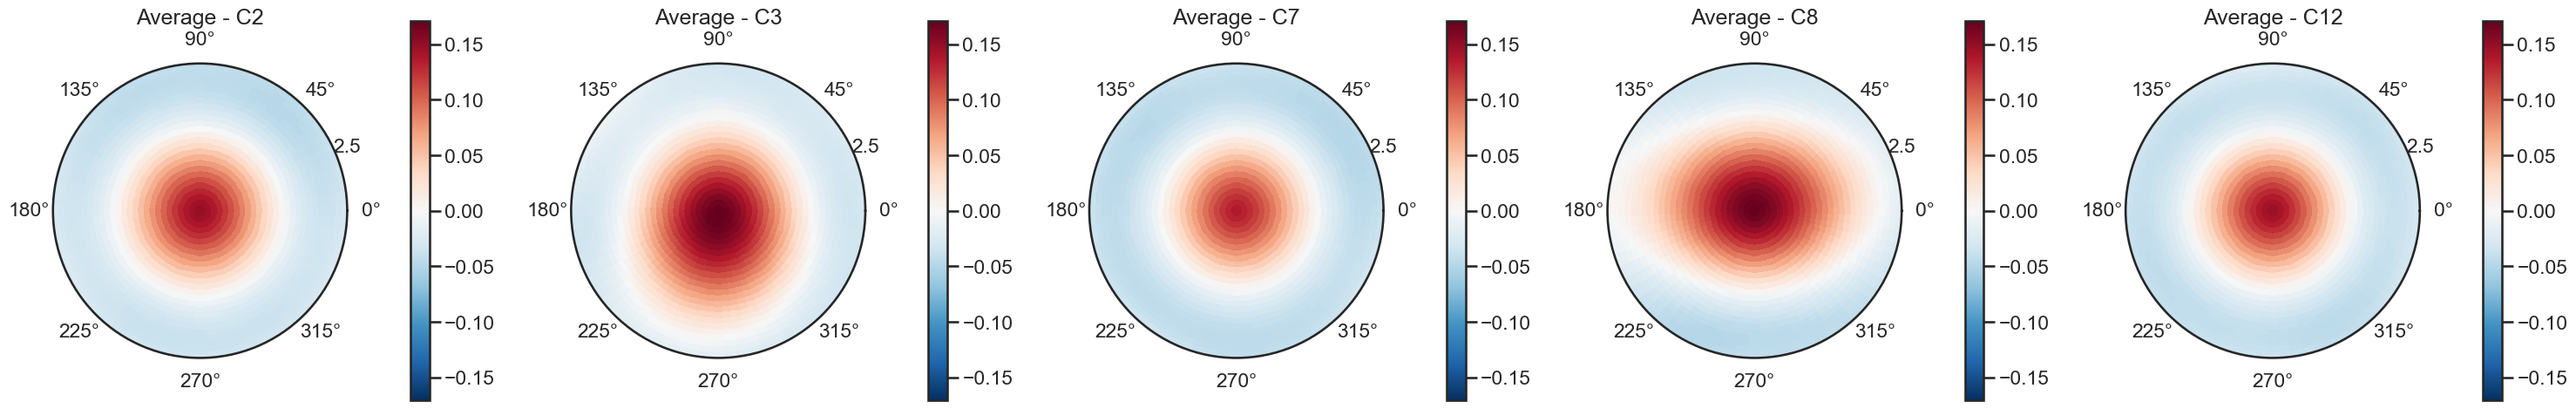

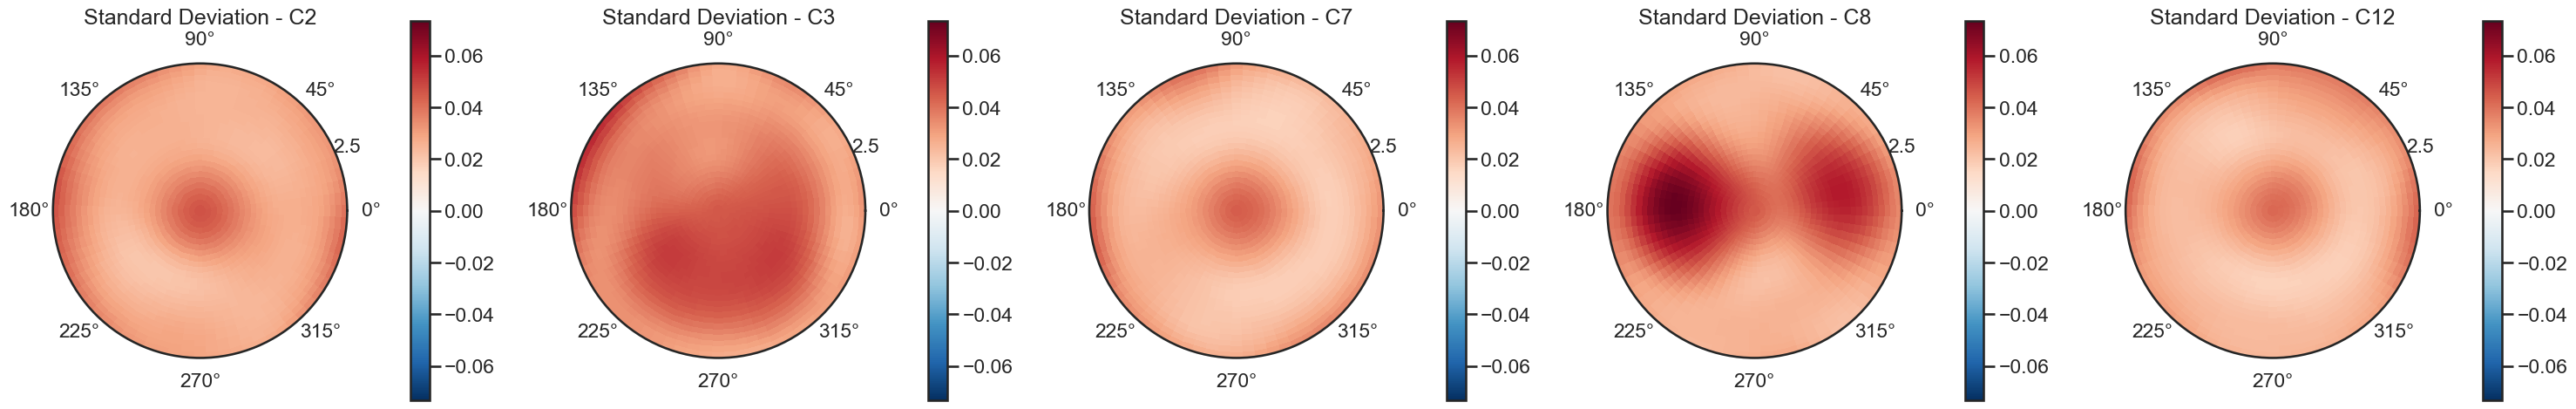

In [14]:
df_stats_filtered = get_filtered_statistics_df(PSII_esp, ["C2", "C3", "C7", "C8", "C12"], 0, 3)

# Generate the z-scores DataFrame
zscores_df = get_zscores_df(PSII_esp, df_stats_filtered, "C7")

polar_plot_df(df_stats_filtered, cmap = "RdBu_r")

# Distribution of Chl local resolution in a map 

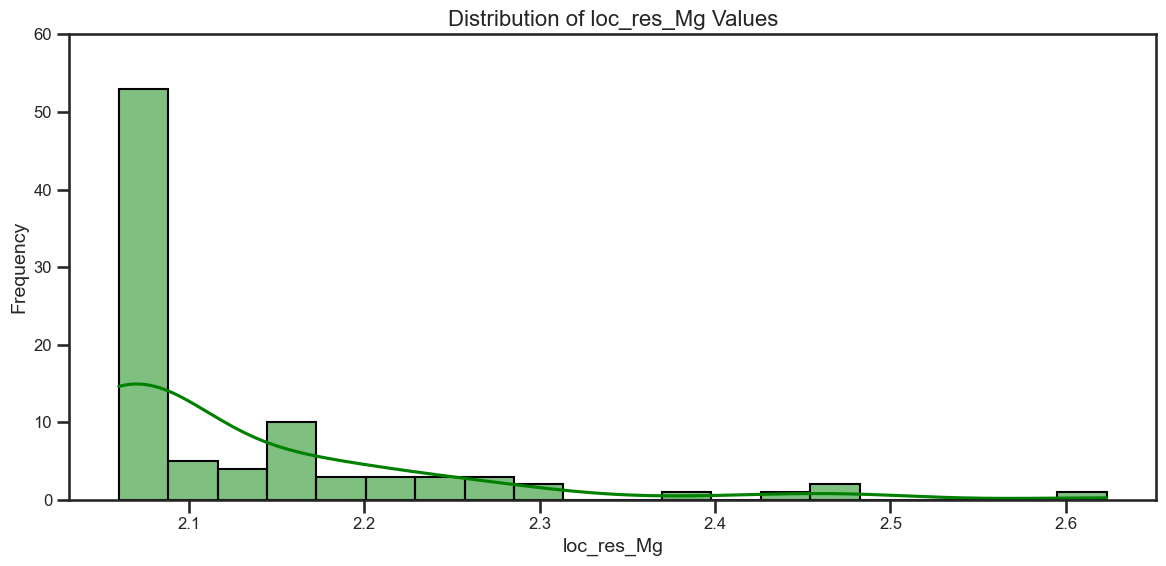

In [15]:
plot_loc_res_mg_distribution(PSII_esp, bins=20, kde=True, figsize=(12, 6))

Max Values - Skewness: 0.968, Mean: 2.262, Median: 2.126
Min Values - Skewness: -0.565, Mean: -1.813, Median: -1.714


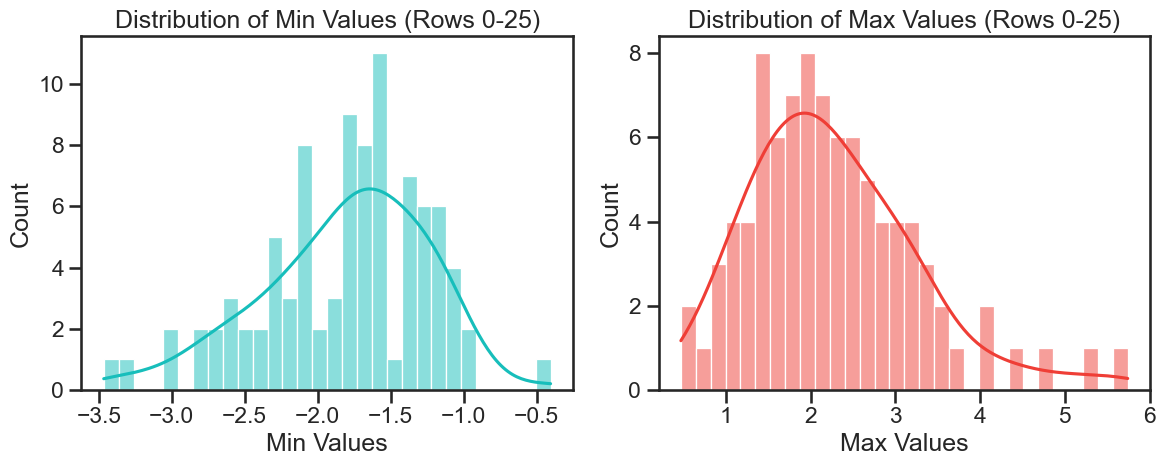

In [16]:
analyze_min_max_distributions(zscores_df, "C7", row_range=(0, 26))

# Quality of the analysis

['A1012', 'A1108', 'A1110', 'A1121', 'A1123', 'B1207', 'B1209', 'B1230', 'B1234', 'B1237', 'L1503']


/var/folders/qn/2_xjlk0x073ft9zqwbzn9qdw0000gn/T/ipykernel_31219/319030184.py:395: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(


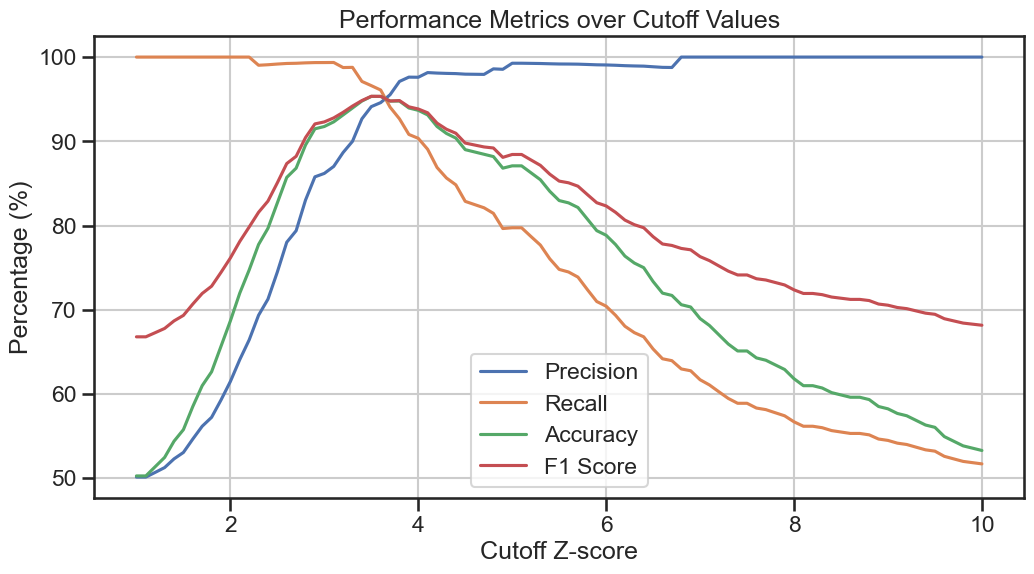

In [17]:
outlier_chlorophylls = find_outlier_chlorophylls_by_distance(zscores_df, "C2", cutoff=3.8, distance=2)
print(outlier_chlorophylls)

plot_metrics_over_cutoffs(zscores_df, start_cutoff=1, end_cutoff=10, step=0.1, distance=2)

# Check for outliers and values of maximum and minimum Z-scores

A1012
Highest Z-score value: 4.709263121104588
Lowest Z-score value: -3.143281730384529


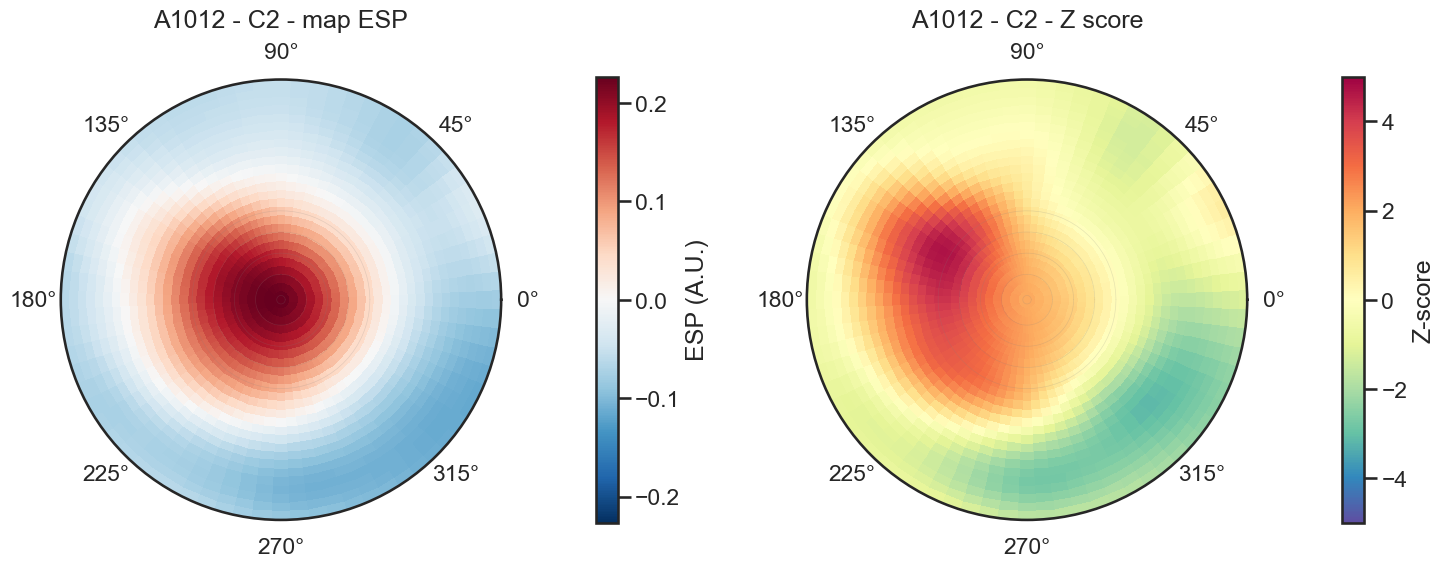

A1108
Highest Z-score value: 4.615155113152819
Lowest Z-score value: -0.9579870802892366


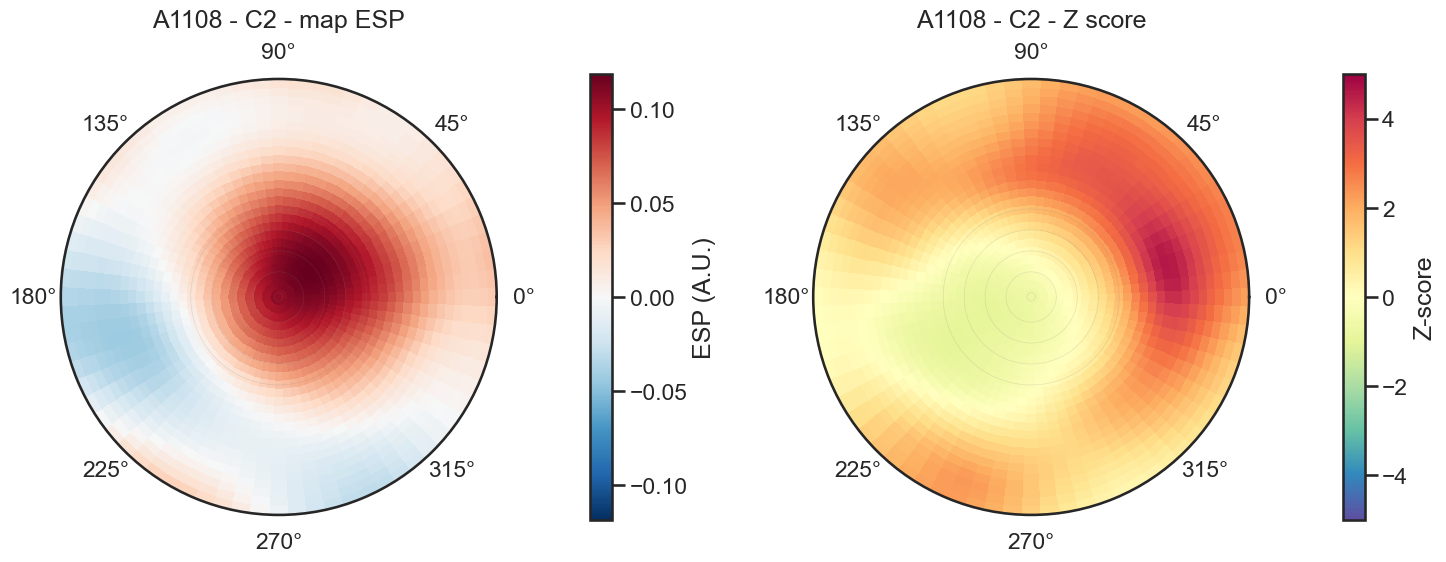

A1110
Highest Z-score value: 5.180719972927104
Lowest Z-score value: -0.838969809633222


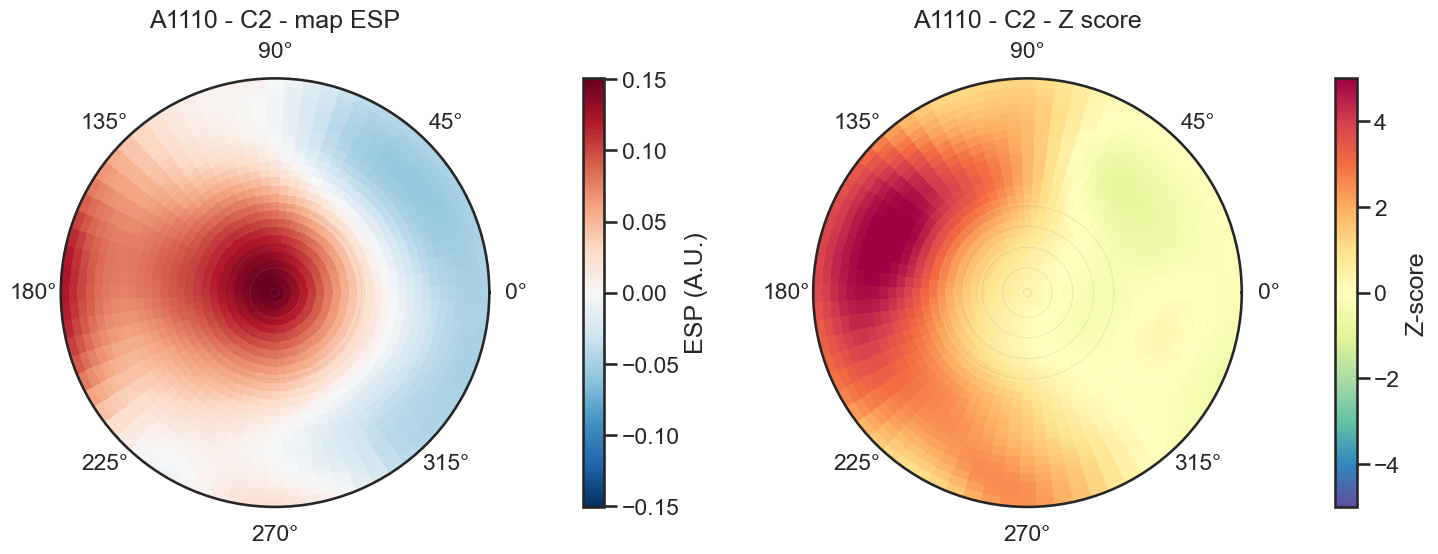

A1121
Highest Z-score value: 4.494096214496606
Lowest Z-score value: -0.6468643500824821


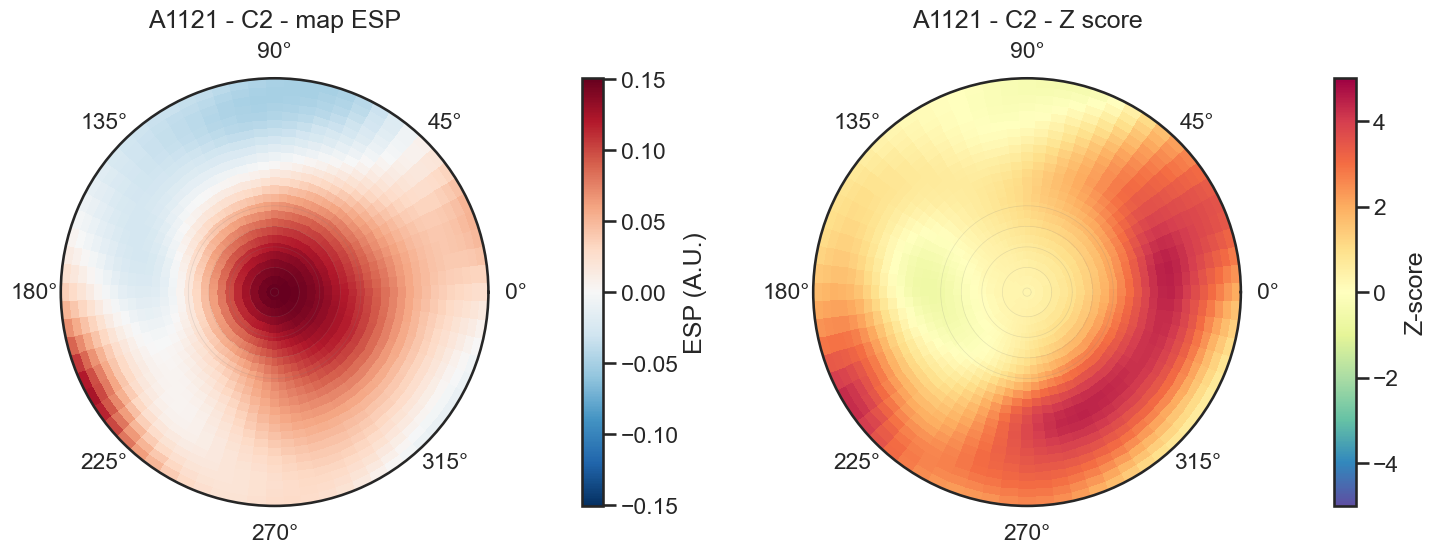

A1123
Highest Z-score value: 4.99251806230155
Lowest Z-score value: -1.6905069025326669


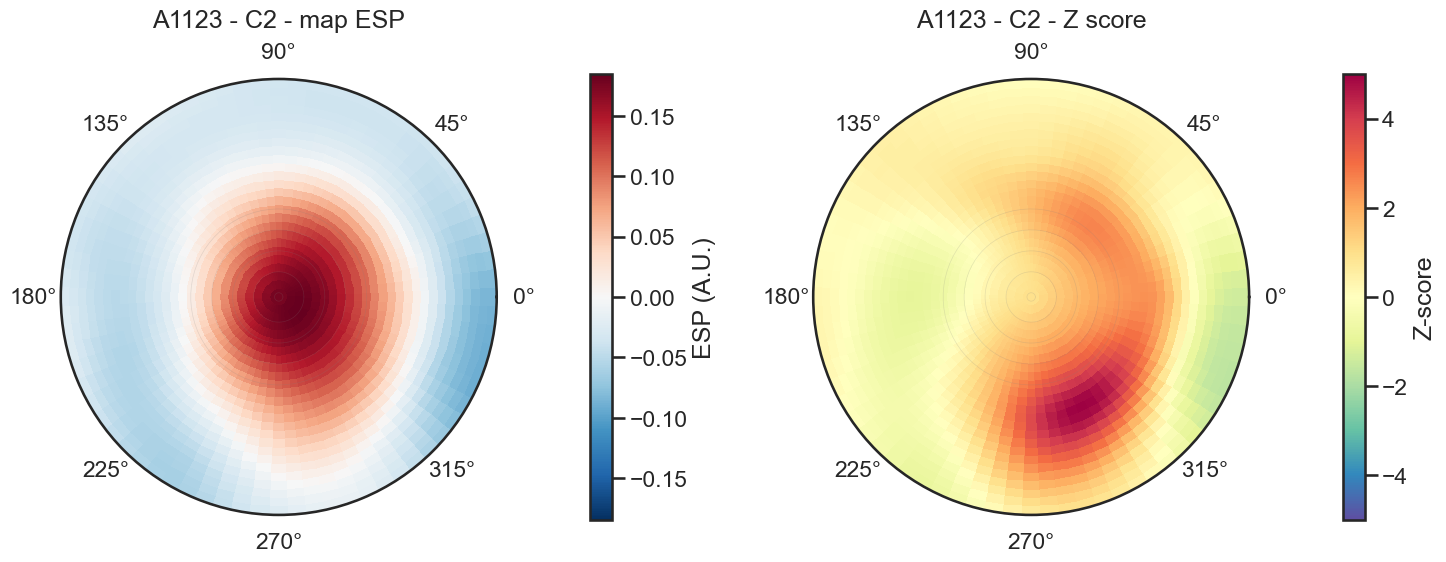

B1207
Highest Z-score value: 8.4262108812938
Lowest Z-score value: -1.4247291466331202


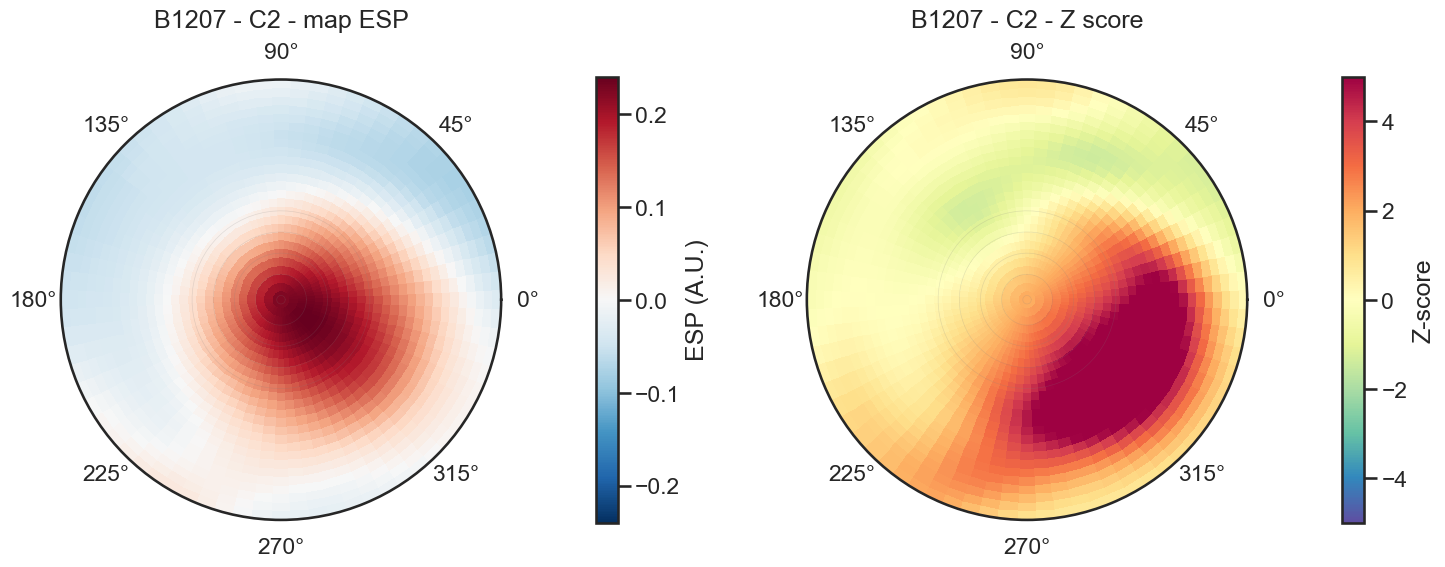

B1209
Highest Z-score value: 5.647086597428638
Lowest Z-score value: -0.7404368919253818


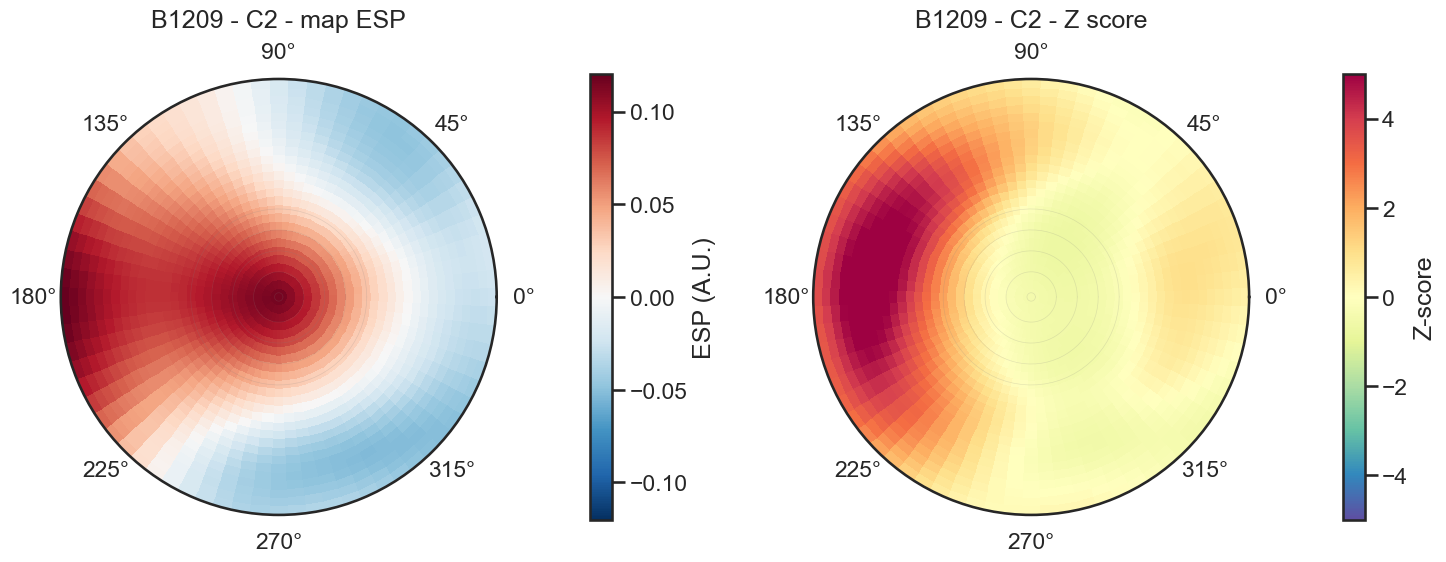

B1230
Highest Z-score value: 4.857459193390811
Lowest Z-score value: -1.842366450153746


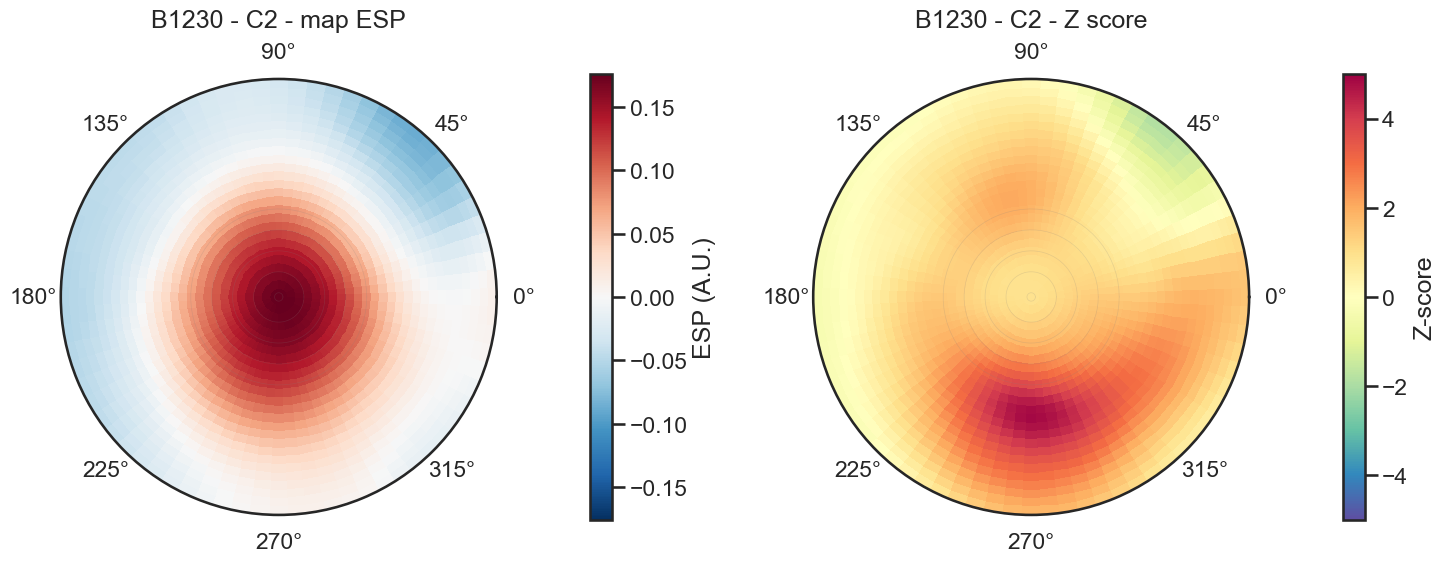

B1237
Highest Z-score value: 7.396968408327038
Lowest Z-score value: -1.6535061326640974


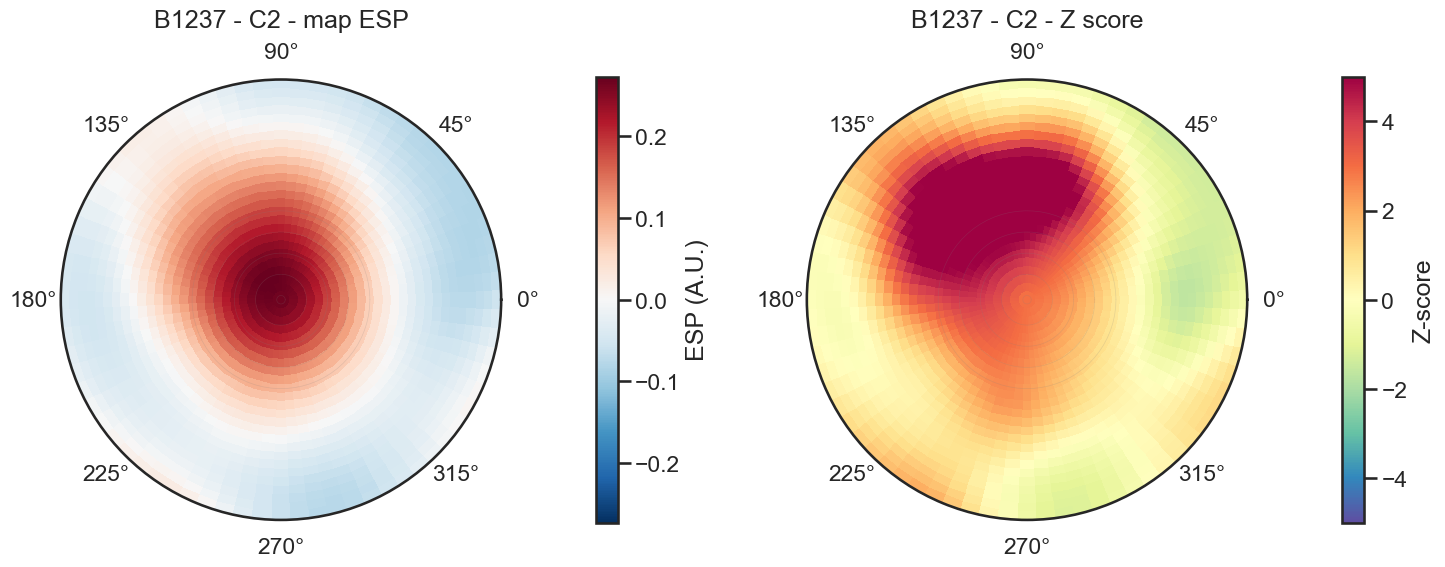

L1503
Highest Z-score value: 4.473505751174998
Lowest Z-score value: -0.8703861075590826


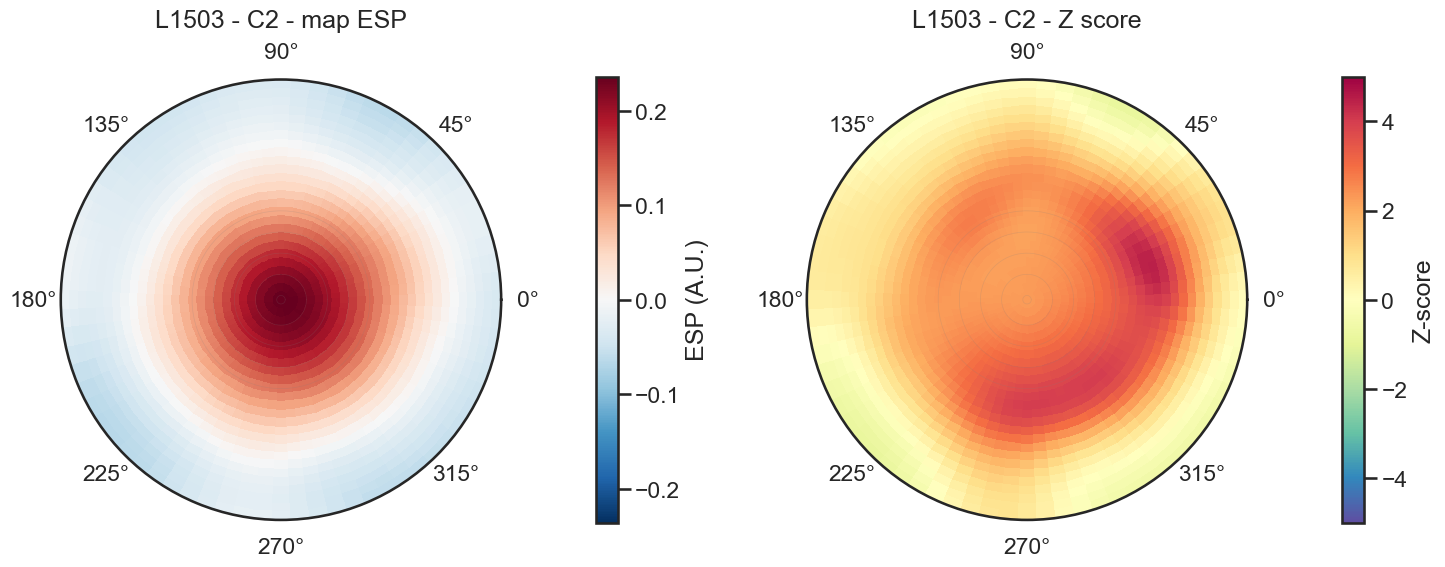

In [18]:
outliers = find_outlier_chlorophylls_by_distance(zscores_df, "C2", cutoff=4, distance=2)

for candidate in outliers: 
    print(candidate)
    print_extreme_values(zscores_df, candidate, "C2")
    polar_plot_substituent(PSII_esp, zscores_df, [candidate], "C2")